In [1]:
%matplotlib inline
%precision 3

import montecarlo
import plot
import metrics
from decimal import Decimal
import simulate
import pandas
from pprint import pprint
import metrics
import withdrawal
import harvesting
import mortality

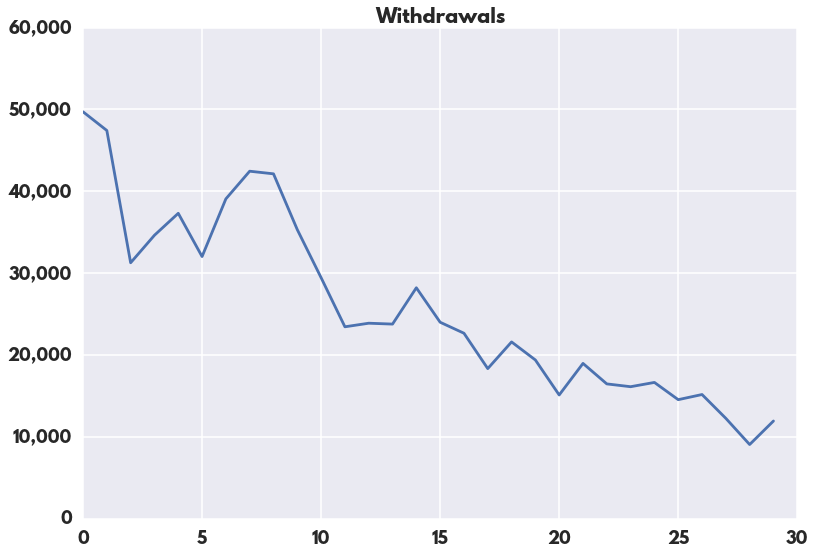

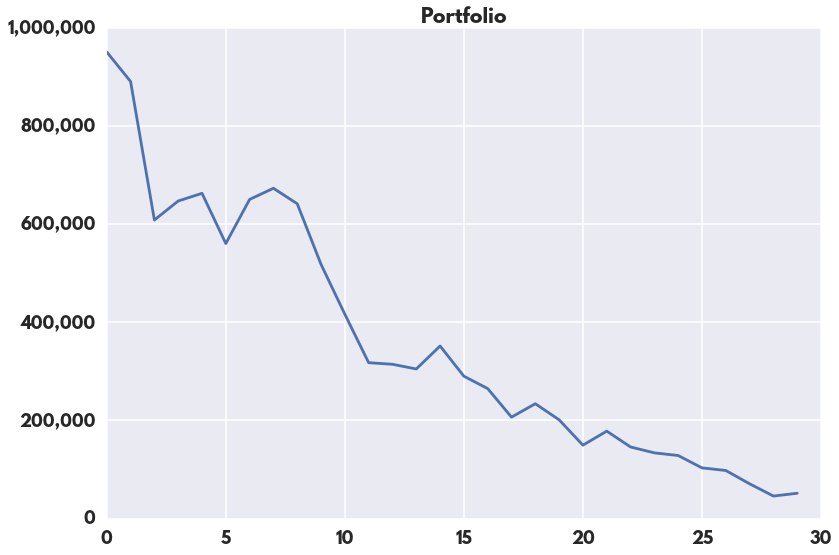

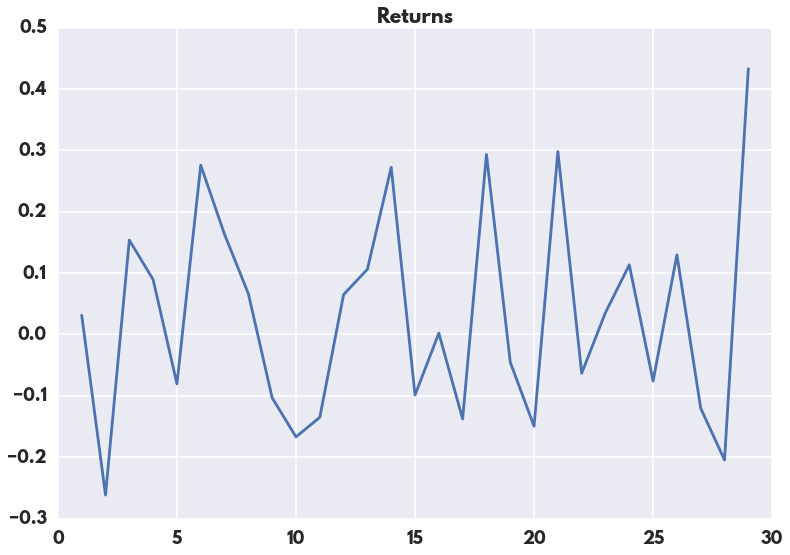

In [2]:
r = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), years=30, withdraw=withdrawal.VPW)
plot.plot([n.withdraw_r for n in r], title='Withdrawals')
plot.plot([n.portfolio_r for n in r], title='Portfolio')
plot.plot([n.returns for n in r], title='Returns', add_commas=False, zero_based=False)

In [3]:
pprint(['%.2f' % float(n.returns) for n in r[1:]])

['0.03',
 '-0.26',
 '0.15',
 '0.09',
 '-0.08',
 '0.28',
 '0.16',
 '0.07',
 '-0.10',
 '-0.17',
 '-0.14',
 '0.06',
 '0.11',
 '0.27',
 '-0.10',
 '0.00',
 '-0.14',
 '0.29',
 '-0.05',
 '-0.15',
 '0.30',
 '-0.06',
 '0.04',
 '0.11',
 '-0.08',
 '0.13',
 '-0.12',
 '-0.20',
 '0.43']


In [4]:
def harness(iters, sim):
    successes = 0
    incomes = pandas.Series(iters)
    for i in range(iters):
        sim_results = sim()
        incomes.loc[i] = float(metrics.cew([(n.withdraw_pct_orig * 100) + Decimal('.01') for n in sim_results]))
        if sim_results[-1].portfolio_n > 0:
            successes += 1
    return (successes/iters, incomes)

def p_q(incomes):
    print('90th percentile income', incomes.quantile(.9))
    print('50th percentile income', incomes.quantile(.5))
    print('10th percentile income', incomes.quantile(.1))
    print('5th percentile income', incomes.quantile(.05))
    print('1st percentile income', incomes.quantile(.01))   

In [11]:
iters = 5000
EM = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsHighValuations(), years=30))
VPW = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsHighValuations(),harvesting=harvesting.N_60_RebalanceHarvesting, withdraw=withdrawal.VPW, years=30))
#ECM = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), withdraw=withdrawal.ECM, years=30))
VG = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsHighValuations(), withdraw=withdrawal.Vanguard, years=30))

In [12]:
for i in (EM, VG, VPW):
    print('Success rate', i[0])
    p_q(i[1])
    print()

Success rate 0.5792
90th percentile income 4.37221350161
50th percentile income 2.84692691881
10th percentile income 0.0135120015445
5th percentile income 0.0128508585206
1st percentile income 0.0120989673492

Success rate 0.555
90th percentile income 3.87752601315
50th percentile income 2.54620078822
10th percentile income 0.0128508585219
5th percentile income 0.012325214199
1st percentile income 0.0117017365964

Success rate 1.0
90th percentile income 4.35137145518
50th percentile income 2.62490802119
10th percentile income 1.46241786615
5th percentile income 1.2450669197
1st percentile income 0.900139741709



In [7]:
def run_one(years, stock_pct, a=None):
    bond_pct = (1 - stock_pct)
    
    if not a:
        a = montecarlo.LowYieldsAutoRegression(initial_yield=.025)
    
    returns = []
    
    for i, j in zip(range(years+1), a):
        stocks = float(j.stocks - j.inflation)
        bonds = float(j.bonds - j.inflation)
        total_return = (stocks * stock_pct) + (bonds * bond_pct)
        returns.append(total_return)
    return returns

In [8]:
a = montecarlo.LowYieldsAutoRegression(initial_yield=.025, logging=True)
run_one(30, .6, a=a)
print('inflation', a.log['inflation'].mean())
print('stocks', a.log['stocks'].mean())
print('bonds', a.log['bonds'].mean())
print('-' * 65)
print(a.log)

NameError: name 'year' is not defined

In [ ]:
iters = 100

s = pandas.Series(iters)

for i in range(iters):
    years = 30
    stock_pct = .6
    ssr = metrics.ssr([Decimal(n) for n in run_one(years, stock_pct)])
    s[i] = float(ssr)

In [ ]:
s.median()

In [ ]:
rates = pandas.Series(100)
for i in range(0, 100):
    q = s.quantile((100-i)/100)
    rates[i] = q * 100
rates.plot()

In [ ]:
survival_fn = mortality.make_mortality(mortality.NVSS_2011)
iters = 100
successes = 0
for i in range(iters):
    final_age = mortality.gen_age(survival_fn)
    sim_results = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(),
                         harvesting=harvesting.make_rebalancer(.6),
                         withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=Decimal('.033')),
                         years=final_age - 65)
    if sim_results[-1].portfolio_n > 0:
        successes += 1
print(successes/iters)

In [ ]:
iters = 100
successes = 0
couple = [mortality.Person(age=65, gender=mortality.MALE), mortality.Person(age=60, gender=mortality.FEMALE)]
for i in range(iters):
    final_age = 65 + mortality.gen_lifespan(couple)
    sim_results = simulate.withdrawals(montecarlo.historical[60],
                         harvesting=harvesting.make_rebalancer(.6),
                         withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=Decimal('.05')),
                         years=final_age - 65)
    if sim_results[-1].portfolio_n > 0:
        successes += 1
print(successes/iters)